In [1]:
import os
from os.path import realpath, join

import drjit as dr
import mitsuba as mi

mi.set_variant('cuda_ad_rgb')

In [93]:
SCENE_DIR = realpath('../scenes/caustics-optimization/')

CONFIGS = {
    'lena': {
        'emitter': 'gray',
        'reference': join(SCENE_DIR, 'references/lena.png'),
    },
    'sunday': {
        'emitter': 'bayer',
        'reference': join(SCENE_DIR, 'references/sunday-512.jpg'),
    },
}

# Pick one of the available configs
config_name = 'lena'
# config_name = 'sunday'

config = CONFIGS[config_name]

# Add common options
config.update({
    'render_resolution': (64, 64),
    'heightmap_resolution': (256, 256),
    'spp': 64,
    'max_iterations': 115,
    'learning_rate': 3e-5,
})

print('[i] Reference image selected:', config['reference'])

output_dir = realpath(join('.', 'outputs', config_name))
os.makedirs(output_dir, exist_ok=True)
print('[i] Results will be saved to:', output_dir)

[i] Reference image selected: C:\Users\saipc\OneDrive\Desktop\SAPO DOX\Studium\Uni Wien\BachelorThesis\python\mitsuba3-tutorial\scenes\caustics-optimization\references/lena.png
[i] Results will be saved to: C:\Users\saipc\OneDrive\Desktop\SAPO DOX\Studium\Uni Wien\BachelorThesis\python\mitsuba3-tutorial\readthedocs-rendering\outputs\lena


In [94]:
# Make sure that resources from the scene directory can be found
mi.Thread.thread().file_resolver().append(SCENE_DIR)

In [95]:
def create_flat_lens_mesh(resolution):
    # Generate UV coordinates
    U, V = dr.meshgrid(
        dr.linspace(mi.Float, 0, 1, resolution[0]),
        dr.linspace(mi.Float, 0, 1, resolution[1]),
        indexing='ij'
    )
    texcoords = mi.Vector2f(U, V)

    # Generate vertex coordinates
    X = 2.0 * (U - 0.5)
    Y = 2.0 * (V - 0.5)
    vertices = mi.Vector3f(X, Y, 0.0)

    # Create two triangles per grid cell
    faces_x, faces_y, faces_z = [], [], []
    for i in range(resolution[0] - 1):
        for j in range(resolution[1] - 1):
            v00 = i * resolution[1] + j
            v01 = v00 + 1
            v10 = (i + 1) * resolution[1] + j
            v11 = v10 + 1
            faces_x.extend([v00, v01])
            faces_y.extend([v10, v10])
            faces_z.extend([v01, v11])

    # Assemble face buffer
    faces = mi.Vector3u(faces_x, faces_y, faces_z)

    # Instantiate the mesh object
    mesh = mi.Mesh("lens-mesh", resolution[0] * resolution[1], len(faces_x), has_vertex_texcoords=True)

    # Set its buffers
    mesh_params = mi.traverse(mesh)
    mesh_params['vertex_positions'] = dr.ravel(vertices)
    mesh_params['vertex_texcoords'] = dr.ravel(texcoords)
    mesh_params['faces'] = dr.ravel(faces)
    mesh_params.update()

    return mesh

In [96]:
lens_res = config.get('lens_res', config['heightmap_resolution'])
lens_fname = join(output_dir, 'lens_{}_{}.ply'.format(*lens_res))

if not os.path.isfile(lens_fname):
    m = create_flat_lens_mesh(lens_res)
    m.write_ply(lens_fname)
    print('[+] Wrote lens mesh ({}x{} tesselation) file to: {}'.format(*lens_res, lens_fname))

2022-10-16 12:00:07 INFO main [Mesh] Writing mesh to "C:\Users\saipc\OneDrive\Desktop\SAPO DOX\Studium\Uni Wien\BachelorThesis\python\mitsuba3-tutorial\readthedocs-rendering\outputs\lena\lens_256_256.ply" ..

2022-10-16 12:00:07 INFO main [Mesh] "C:\Users\saipc\OneDrive\Desktop\SAPO DOX\Studium\Uni Wien\BachelorThesis\python\mitsuba3-tutorial\readthedocs-rendering\outputs\lena\lens_256_256.ply": wrote 130050 faces, 65536 vertices (2.74 MiB in 27ms)

[+] Wrote lens mesh (256x256 tesselation) file to: C:\Users\saipc\OneDrive\Desktop\SAPO DOX\Studium\Uni Wien\BachelorThesis\python\mitsuba3-tutorial\readthedocs-rendering\outputs\lena\lens_256_256.ply


In [97]:
emitter = None
if config['emitter'] == 'gray':
    emitter = {
        'type':'directionalarea',
        'radiance': {
            'type': 'spectrum',
            'value': 0.8
        },
    }
elif config['emitter'] == 'bayer':
    bayer = dr.zeros(mi.TensorXf, (32, 32, 3))
    bayer[ ::2,  ::2, 2] = 2.2
    bayer[ ::2, 1::2, 1] = 2.2
    bayer[1::2, 1::2, 0] = 2.2

    emitter = {
        'type':'directionalarea',
        'radiance': {
            'type': 'bitmap',
            'bitmap': mi.Bitmap(bayer),
            'raw': True,
            'filter_type': 'nearest'
        },
    }

In [98]:
# Looking at the receiving plane, not looking through the lens
sensor_to_world = mi.ScalarTransform4f.look_at(
    target=[0, -20, 0],
    origin=[0, -4.65, 0],
    up=[0, 0, 1]
)
resx, resy = config['render_resolution']
sensor = {
    'type': 'perspective',
    'near_clip': 1,
    'far_clip': 1000,
    'fov': 45,
    'to_world': sensor_to_world,

    'sampler': {
        'type': 'independent',
        'sample_count': 512  # Not really used
    },
    'film': {
        'type': 'hdrfilm',
        'width': resx,
        'height': resy,
        'pixel_format': 'rgb',
        'rfilter': {
            # Important: smooth reconstruction filter with a footprint larger than 1 pixel.
            'type': 'gaussian'
        }
    },
}

In [99]:
integrator = {
    'type': 'ptracer',
    'samples_per_pass': 256,
    'max_depth': 4,
    'hide_emitters': False,
}

In [100]:
scene = {
    'type': 'scene',
    'sensor': sensor,
    'integrator': integrator,
    # Glass BSDF
    'simple-glass': {
        'type': 'dielectric',
        'id': 'simple-glass-bsdf',
        'ext_ior': 'air',
        'int_ior': 1.5,
        'specular_reflectance': { 'type': 'spectrum', 'value': 0 },
    },
    'white-bsdf': {
        'type': 'diffuse',
        'id': 'white-bsdf',
        'reflectance': { 'type': 'rgb', 'value': (1, 1, 1) },
    },
    'black-bsdf': {
        'type': 'diffuse',
        'id': 'black-bsdf',
        'reflectance': { 'type': 'spectrum', 'value': 0 },
    },
    # Receiving plane
    'receiving-plane': {
        'type': 'obj',
        'id': 'receiving-plane',
        'filename': 'meshes/rectangle.obj',
        'to_world': \
            mi.ScalarTransform4f.look_at(
                target=[0, 1, 0],
                origin=[0, -7, 0],
                up=[0, 0, 1]
            ).scale((5, 5, 5)),
        'bsdf': {'type': 'ref', 'id': 'white-bsdf'},
    },
    # Glass slab, excluding the 'exit' face (added separately below)
    'slab': {
        'type': 'obj',
        'id': 'slab',
        'filename': 'meshes/slab.obj',
        'to_world': mi.ScalarTransform4f.rotate(axis=(1, 0, 0), angle=90),
        'bsdf': {'type': 'ref', 'id': 'simple-glass'},
    },
    # Glass rectangle, to be optimized
    'lens': {
        'type': 'ply',
        'id': 'lens',
        'filename': lens_fname,
        'to_world': mi.ScalarTransform4f.rotate(axis=(1, 0, 0), angle=90),
        'bsdf': {'type': 'ref', 'id': 'simple-glass'},
    },

    # Directional area emitter placed behind the glass slab
    'focused-emitter-shape': {
        'type': 'obj',
        'filename': 'meshes/rectangle.obj',
        'to_world': mi.ScalarTransform4f.look_at(
            target=[0, 0, 0],
            origin=[0, 5, 0],
            up=[0, 0, 1]
        ),
        'bsdf': {'type': 'ref', 'id': 'black-bsdf'},
        'focused-emitter': emitter,
    },
}

In [101]:
scene = mi.load_dict(scene)

2022-10-16 12:00:07 INFO main [Scene] Building scene in OptiX ..

2022-10-16 12:00:07 INFO main [Scene] OptiX ready. (took 5ms)

In [102]:
def load_ref_image(config, resolution, output_dir):
    b = mi.Bitmap(config['reference'])
    b = b.convert(mi.Bitmap.PixelFormat.RGB, mi.Bitmap.Float32, False)
    if b.size() != resolution:
        b = b.resample(resolution)

    mi.util.write_bitmap(join(output_dir, 'out_ref.exr'), b)

    print('[i] Loaded reference image from:', config['reference'])
    return mi.TensorXf(b)

# Make sure the reference image will have a resolution matching the sensor
sensor = scene.sensors()[0]
crop_size = sensor.film().crop_size()
image_ref = load_ref_image(config, crop_size, output_dir=output_dir)
scaled_image_ref = image_ref / dr.mean(image_ref)
dr.eval(scaled_image_ref)

[i] Loaded reference image from: C:\Users\saipc\OneDrive\Desktop\SAPO DOX\Studium\Uni Wien\BachelorThesis\python\mitsuba3-tutorial\scenes\caustics-optimization\references/lena.png


In [103]:
heightmap_texture = mi.load_dict({
    'type': 'bitmap',
    'id': 'heightmap_texture',
    'bitmap': mi.Bitmap(dr.zeros(mi.TensorXf, config['heightmap_resolution'])),
    'raw': True,
})

# Actually optimized: the heightmap texture
params = mi.traverse(heightmap_texture)
params.keep(['data'])
opt = mi.ad.Adam(lr=config['learning_rate'], params=params)

In [104]:
params_scene = mi.traverse(scene)

# We will always apply displacements along the original normals and
# starting from the original positions.
positions_initial = dr.unravel(mi.Vector3f, params_scene['lens.vertex_positions'])
normals_initial   = dr.unravel(mi.Vector3f, params_scene['lens.vertex_normals'])

lens_si = dr.zeros(mi.SurfaceInteraction3f, dr.width(positions_initial))
lens_si.uv = dr.unravel(type(lens_si.uv), params_scene['lens.vertex_texcoords'])

def apply_displacement(amplitude = 1.):
    # Enforce reasonable range. For reference, the receiving plane
    # is 7 scene units away from the lens.
    vmax = 1 / 100.
    params['data'] = dr.clamp(params['data'], -vmax, vmax)
    dr.enable_grad(params['data'])

    height_values = heightmap_texture.eval_1(lens_si)
    new_positions = (height_values * normals_initial * amplitude + positions_initial)
    params_scene['lens.vertex_positions'] = dr.ravel(new_positions)
    params_scene.update()

In [105]:
import time
start_time = time.time()
mi.set_log_level(mi.LogLevel.Warn)
iterations = config['max_iterations']
loss_values = []

for it in range(iterations):
    t0 = time.time()

    # Apply displacement and update the scene BHV accordingly
    apply_displacement()

    # Perform a differentiable rendering of the scene
    image = mi.render(scene, params, seed=it, spp=config['spp'])

    # Scale-independent L2 function
    loss = dr.mean(dr.sqr((image / dr.mean(dr.detach(image))) - scaled_image_ref))

    # Back-propagate errors to input parameters and take an optimizer step
    dr.backward(loss)

    # Take a gradient step
    opt.step()

    # Carry over the update to our "latent variable" (the heightmap values)
    params.update(opt)

    # Log progress
    elapsed_ms = 1000. * (time.time() - t0)
    current_loss = loss[0]
    loss_values.append(current_loss)
    mi.Thread.thread().logger().log_progress(
        it / (iterations-1),
        f'Iteration {it:03d}: loss={current_loss:g} (took {elapsed_ms:.0f}ms)',
        'Caustic Optimization', '')


end_time = time.time()
print(((end_time - start_time) * 1000) / iterations, ' ms per iteration on average')
mi.set_log_level(mi.LogLevel.Info)

149.73953495854917  ms per iteration on average


In [106]:
fname = join(output_dir, 'heightmap_final.exr')
mi.util.write_bitmap(fname, params['data'])
print('[+] Saved final heightmap state to:', fname)

fname = join(output_dir, 'lens_displaced.ply')
apply_displacement()
lens_mesh = [m for m in scene.shapes() if m.id() == 'lens'][0]
lens_mesh.write_ply(fname)
print('[+] Saved displaced lens to:', fname)

[+] Saved final heightmap state to: C:\Users\saipc\OneDrive\Desktop\SAPO DOX\Studium\Uni Wien\BachelorThesis\python\mitsuba3-tutorial\readthedocs-rendering\outputs\lena\heightmap_final.exr


2022-10-16 12:00:25 INFO main [Mesh] Writing mesh to "C:\Users\saipc\OneDrive\Desktop\SAPO DOX\Studium\Uni Wien\BachelorThesis\python\mitsuba3-tutorial\readthedocs-rendering\outputs\lena\lens_displaced.ply" ..

2022-10-16 12:00:25 INFO main [Mesh] "C:\Users\saipc\OneDrive\Desktop\SAPO DOX\Studium\Uni Wien\BachelorThesis\python\mitsuba3-tutorial\readthedocs-rendering\outputs\lena\lens_displaced.ply": wrote 130050 faces, 65536 vertices (3.49 MiB in 72ms)

[+] Saved displaced lens to: C:\Users\saipc\OneDrive\Desktop\SAPO DOX\Studium\Uni Wien\BachelorThesis\python\mitsuba3-tutorial\readthedocs-rendering\outputs\lena\lens_displaced.ply


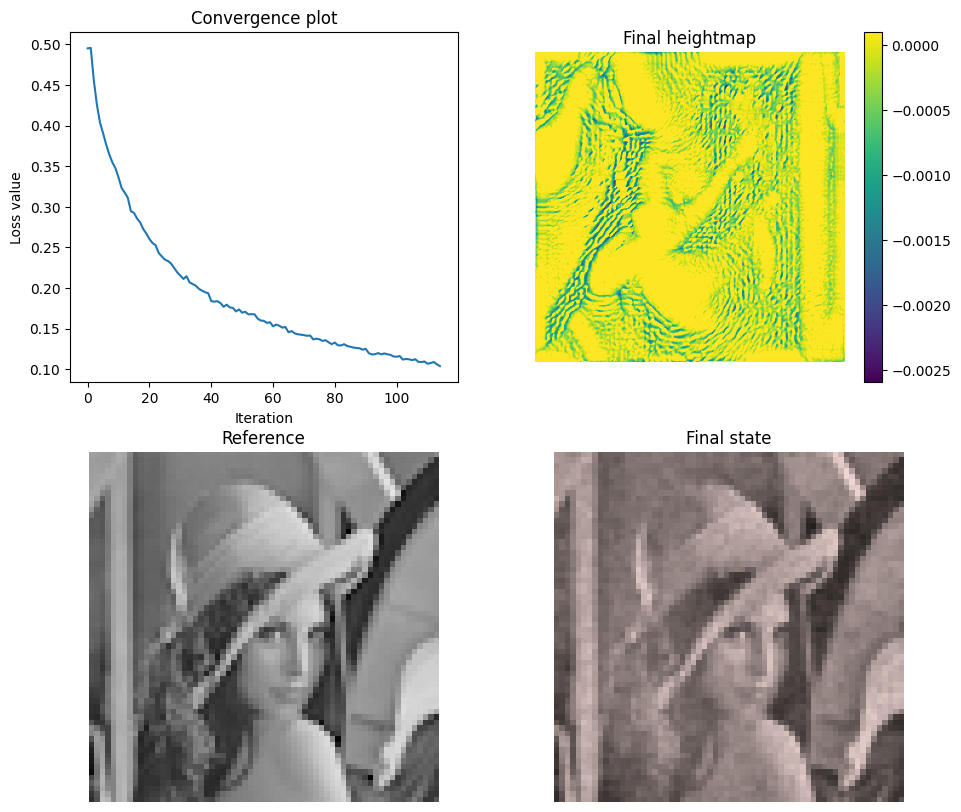

In [107]:
import matplotlib.pyplot as plt

def show_image(ax, img, title):
    ax.imshow(mi.util.convert_to_bitmap(img))
    ax.axis('off')
    ax.set_title(title)

def show_heightmap(fig, ax, values, title):
    values = params['data'].numpy().reshape(lens_res)
    im = ax.imshow(values, vmax=1e-4)
    fig.colorbar(im, ax=ax)
    ax.axis('off')
    ax.set_title(title)

fig, ax = plt.subplots(2, 2, figsize=(11, 10))
ax = ax.ravel()
ax[0].plot(loss_values)
ax[0].set_xlabel('Iteration'); ax[0].set_ylabel('Loss value'); ax[0].set_title('Convergence plot')

show_heightmap(fig, ax[1], params['data'], 'Final heightmap')
show_image(ax[2], image_ref, 'Reference')
show_image(ax[3], image,     'Final state')
plt.show()